In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [13]:
run = wandb.init(project="convolutional-nn", id="wider-conv-layers-3-small-dataset")

In [14]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')

wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE})

In [15]:
data_path = 'Data/animals'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/animals',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/animals',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


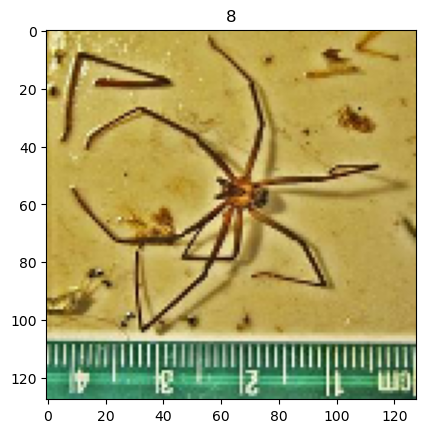

In [17]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [21]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)      

In [22]:
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[WandbCallback()])

Epoch 1/5


2023-04-04 17:24:43.495787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 17:24:44.359129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:24:44.867235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:24:45.208099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:24:45.902875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:24:45.971373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:24:46.015144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:24:47.178940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:24:47.883236: W ten

655/655 [==============================] - ETA: 0s - loss: 1.6339 - sparse_categorical_accuracy: 0.4376 - sparse_categorical_crossentropy: 1.6339

2023-04-04 17:25:31.941080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 17:25:32.750564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:25:33.655243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:25:34.026218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:25:34.262876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:25:34.505489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:25:34.546830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-04 17:25:34.612449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 53s 67ms/step - loss: 1.6339 - sparse_categorical_accuracy: 0.4376 - sparse_categorical_crossentropy: 1.6339 - val_loss: 1.3115 - val_sparse_categorical_accuracy: 0.5500 - val_sparse_categorical_crossentropy: 1.3115
Epoch 2/5
655/655 [==============================] - 45s 68ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.6141 - sparse_categorical_crossentropy: 1.1365 - val_loss: 1.0813 - val_sparse_categorical_accuracy: 0.6288 - val_sparse_categorical_crossentropy: 1.0813
Epoch 3/5
655/655 [==============================] - 44s 67ms/step - loss: 0.8371 - sparse_categorical_accuracy: 0.7189 - sparse_categorical_crossentropy: 0.8371 - val_loss: 1.0169 - val_sparse_categorical_accuracy: 0.6632 - val_sparse_categorical_crossentropy: 1.0169
Epoch 4/5
655/655 [==============================] - 43s 66ms/step - loss: 0.5774 - sparse_categorical_accuracy: 0.8040 - sparse_categorical_crossentropy: 0.5774 - val_loss: 1.0259 - val_sparse_categoric

In [23]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy
0,1.633927,0.437643,1.633927,1.311531,0.549952,1.311531
1,1.136461,0.614066,1.136461,1.081269,0.628844,1.081269
2,0.837149,0.718869,0.837149,1.016931,0.663228,1.016931
3,0.577390,0.804049,0.577390,1.025884,0.682330,1.025884
4,0.341561,0.885934,0.341561,1.185582,0.685769,1.185582


In [24]:
model.evaluate(val_ds)

164/164 [==============================] - 4s 22ms/step - loss: 1.1856 - sparse_categorical_accuracy: 0.6858 - sparse_categorical_crossentropy: 1.1856


[1.1855816841125488, 0.6857688426971436, 1.1855816841125488]

In [25]:
tf.keras.models.save_model(model, "model/larger-conv-layers-3-small-dataset.pth")
wandb.save('runs/pima_run_2023-04-04-larger-conv-layers-3-small-dataset')
wandb.finish()

INFO:tensorflow:Assets written to: model/larger-conv-layers-3-small-dataset.pth/assets


INFO:tensorflow:Assets written to: model/larger-conv-layers-3-small-dataset.pth/assets


loss,█▅▄▂▁
sparse_categorical_accuracy,▁▄▅▇█
sparse_categorical_crossentropy,█▅▄▂▁
val_loss,█▃▁▁▅
val_sparse_categorical_accuracy,▁▅▇██
val_sparse_categorical_crossentropy,█▃▁▁▅
loss,0.34156
sparse_categorical_accuracy,0.88593
sparse_categorical_crossentropy,0.34156
val_loss,1.18558
val_sparse_categorical_accuracy,0.68577
